In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline

# Threeler Filter Analysis

In this notebook we'll be developing a model of the [Threeler filter circuit](https://ijfritz.byethost4.com/Threeler_board_doc.pdf).

The model development will be organized as follows:
- Develop a model of the base one-pole filter used by the circuit.
- Extend the model of the one-pole filter to allow for a secondary input (needed for the first filter stage).
- Develop a model of a single filter stag with global feedback.
- Develop a model of the resonance stage.
- Develop a model of the full circuit with three filter stages and a resonance stage.

## One-Pole Filter

For reference, we're going to use [Urs Heckmann's](https://urs.silvrback.com/one-pole-monster) explanation of this circuit as our starting point.

For the OTA in the circuit, we'll use the equation:
$$
i_{ota} = g(\tanh(V_{in}) - \tanh(V_{out}))
$$

Then when taking the Laplace Transform of the circuit, we get:
$$
V_{out} = \frac{g}{Cs}(\tanh(V_{in}) - \tanh(V_{out}))
$$

Then using the [Backwards Euler transform](https://ccrma.stanford.edu/~jos/pasp/Backward_Euler_Method.html), we get the following discretized equation:
$$
V_{out}[n] = \frac{Tg}{C}(\tanh(V_{in}[n]) - \tanh(V_{out}[n])) + V_{out}[n-1]
$$
where $T$ is the sample period of our digital system.

As with Urs' breakdown, we can use the solution for the linear version of this equation as an estimator:
$$
V_{out}[n] = \frac{1}{1 + \frac{Tg}{C}} \left( \frac{Tg}{C} V_{in}[n] + V_{out}[n-1] \right)
$$

First, let's look at the frequency response for the linear case. I've worked out an expression for the filter cutoff frequency, but don't show the derivation here. That's left as an exercise for the reader :).

Text(0.5, 0, 'Frequency [Hz]')

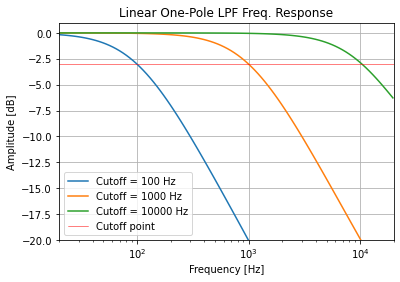

In [11]:
FS = 96000 # sample rate
T = 1.0 / FS # sample time
C = 220e-12 # capacitor value for the circuit

# calculate filter coefs for OTA gain 'g'
def calc_coefs_g(g):
    b_coeff = T * g / C
    a_coeff = 1.0 / (1.0 + b_coeff)
    return b_coeff, a_coeff

# calculate the coefs for filter cutoff frequency (-3dB point)
def calc_coefs_freq(freq):
    g = (C / T) * (np.exp(2 * np.pi * freq / FS) - 1)
    return calc_coefs_g(g)

for freq in [100, 1000, 10000]:
    b_coeff, a_coeff = calc_coefs_freq(freq)
    w, h = signal.freqz([b_coeff * a_coeff, 0], [1.0, -a_coeff], fs=FS, worN=np.logspace(1.0, 3.3, base=20, num=100))
    plt.semilogx(w, 20 * np.log10(abs(h)), label=f'Cutoff = {freq} Hz')

plt.axhline(y=-3, color='r', lw=0.5, label='Cutoff point')
plt.grid()
plt.xlim(20, 20000)
plt.ylim(-20, 1)
plt.legend()
plt.title('Linear One-Pole LPF Freq. Response')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')

Now we can develop the nonlinear model, as Urs did above. For now I've decided to use a one-step version of the Newton-Raphson method, so that if we decide we need more accuracy later, we can just add more iterations. Of course if we determine later that this is too CPU-heavy, we can downgrade to a simpler method.

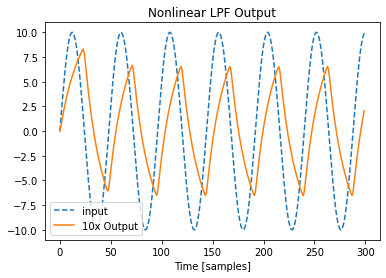

In [3]:
def sech2_with_tanh(tanh_value):
    return 1.0 - tanh_value * tanh_value

class OnePoleLPF:
    def __init__(self, freq):
        self.z = 0
        self.b_coeff, self.a_coeff = calc_coefs_freq(freq)

    def lin_output(self, x):
        return self.a_coeff * (self.b_coeff * x + self.z)

    def nonlin_output(self, tanh_x, tanh_y):
        return self.b_coeff * (tanh_x - tanh_y) + self.z

    def get_derivative(self, tanh_y):
        return -self.b_coeff * sech2_with_tanh(tanh_y) - 1.0

    def process_sample(self, x):
        tanh_x = np.tanh(x)
        estimate = self.lin_output(tanh_x)

        # newton-raphson update
        N_iter = 1
        for n in range(N_iter):
            tanh_y = np.tanh(estimate)
            residue = self.nonlin_output(tanh_x, tanh_y) - estimate
            estimate -= residue / self.get_derivative(tanh_y)

        self.z = estimate
        return estimate

N = 300
freq = 2000
x = 10 * np.sin(2 * np.pi * np.arange(N) * freq / FS)

y = np.zeros_like(x)
one_pole = OnePoleLPF(1000)
for n in range(N):
    y[n] = one_pole.process_sample(x[n])

plt.plot(x, '--', label='input')
plt.plot(10 * y, label='10x Output')
plt.title('Nonlinear LPF Output')
plt.xlabel('Time [samples]')
plt.legend()

Now let's work out the corresponding high-pass filter.

Laplace:
$$
V_{out} = \frac{1}{Cs} (-g \tanh(V_{out})) + V_{in}
$$

Backwards Euler:
$$
V_{out}[n] = -\frac{Tg}{C} \tanh(V_{out}[n]) + V_{in}[n] - V_{in}[n-1] + V_{out}[n-1]
$$

Linear Case:
$$
V_{out}[n] = \frac{1}{1 + \frac{Tg}{C}} (V_{in}[n] - V_{in}[n-1] + V_{out}[n-1])
$$

Text(0.5, 0, 'Frequency [Hz]')

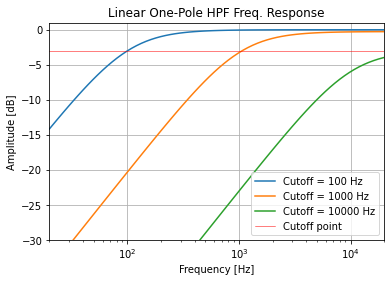

In [12]:
for freq in [100, 1000, 10000]:
    _, a_coeff = calc_coefs_freq(freq)
    w, h = signal.freqz([a_coeff, -a_coeff], [1.0, -a_coeff], fs=FS, worN=np.logspace(1.0, 4.3, base=20, num=100))
    plt.semilogx(w, 20 * np.log10(abs(h)), label=f'Cutoff = {freq} Hz')

plt.axhline(y=-3, color='r', lw=0.5, label='Cutoff point')
plt.grid()
plt.xlim(20, 20000)
plt.ylim(-30, 1)
plt.legend()
plt.title('Linear One-Pole HPF Freq. Response')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')

Note that due to the design of the filter, the filter gain drops off a little bit at high cutoff frequencies.

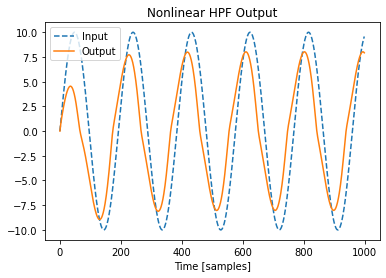

In [5]:
class OnePoleHPF:
    def __init__(self, freq):
        self.z = 0
        self.x1 = 0
        self.b_coeff, self.a_coeff = calc_coefs_freq(freq)

    def lin_output(self, x):
        return self.a_coeff * (x - self.x1 + self.z)

    def nonlin_output(self, x, tanh_y):
        return -self.b_coeff * (tanh_y) + x - self.x1 + self.z

    def get_derivative(self, tanh_y):
        return -self.b_coeff * sech2_with_tanh(tanh_y) - 1.0

    def process_sample(self, x):
        estimate = self.lin_output(x)

        # newton-raphson update
        N_iter = 1
        for n in range(N_iter):
            tanh_y = np.tanh(estimate)
            residue = self.nonlin_output(x, tanh_y) - estimate
            estimate -= residue / self.get_derivative(tanh_y)

        self.z = estimate
        self.x1 = x
        return estimate

N = 1000
freq = 500
x = 10 * np.sin(2 * np.pi * np.arange(N) * freq / FS)

y = np.zeros_like(x)
one_pole = OnePoleHPF(2000)
for n in range(N):
    y[n] = one_pole.process_sample(x[n])

plt.plot(x, '--', label='Input')
plt.plot(y, label='Output')
plt.title('Nonlinear HPF Output')
plt.xlabel('Time [samples]')
plt.legend()

## One-Pole Filter with Feedback Input

So for the second and third stages of the Threeler filter, the above derivations will work. But for the first stage, we have to deal with an additional input signal coming from the feedback path ($V_{fb}$). Here's the lowpass case:

Laplace:
$$
V_{out} - V_{fb} = \frac{g}{Cs}(\tanh(V_{in}) - \tanh(V_{out}))
$$

Backwards Euler:
$$
V_{out}[n] = \frac{Tg}{C}(\tanh(V_{in}[n]) - \tanh(V_{out}[n])) + V_{out}[n-1] - V_{fb}[n] + V_{fb}[n-1]
$$

Linear Case:
$$
V_{out}[n] = \frac{1}{1 + \frac{Tg}{C}} \left( \frac{Tg}{C} V_{in}[n] + V_{out}[n-1] - V_{fb}[n] + V_{fb}[n-1] \right)
$$

To simulate the feedback process, we'll use the output of the filter delayed by one sample as the feedback input.

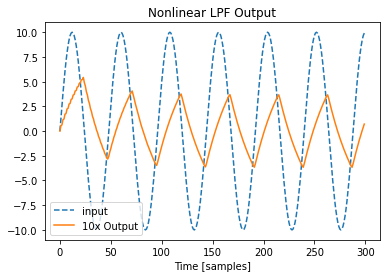

In [6]:
class OnePoleLPF_FB:
    def __init__(self, freq):
        self.z = 0
        self.fb1 = 0
        self.b_coeff, self.a_coeff = calc_coefs_freq(freq)

    def lin_output(self, x, fb):
        return self.a_coeff * (self.b_coeff * x + self.z - fb + self.fb1)

    def nonlin_output(self, tanh_x, tanh_y, fb):
        return self.b_coeff * (tanh_x - tanh_y) + self.z - fb + self.fb1

    def get_derivative(self, tanh_y):
        return -self.b_coeff * sech2_with_tanh(tanh_y) - 1.0

    def process_sample(self, x, fb):
        tanh_x = np.tanh(x)
        estimate = self.lin_output(tanh_x, fb)

        # newton-raphson update
        N_iter = 1
        for n in range(N_iter):
            tanh_y = np.tanh(estimate)
            residue = self.nonlin_output(tanh_x, tanh_y, fb) - estimate
            estimate -= residue / self.get_derivative(tanh_y)

        self.z = estimate
        self.fb1 = fb
        return estimate

N = 300
freq = 2000
x = 10 * np.sin(2 * np.pi * np.arange(N) * freq / FS)

y = np.zeros_like(x)
y1 = 0
one_pole = OnePoleLPF_FB(1000)
for n in range(N):
    y[n] = one_pole.process_sample(x[n], y1)
    y1 = y[n]

plt.plot(x, '--', label='input')
plt.plot(10 * y, label='10x Output')
plt.title('Nonlinear LPF Output')
plt.xlabel('Time [samples]')
plt.legend()

And again, the highpass case:
Laplace:
$$
V_{out} = \frac{1}{Cs} g(\tanh(V_{fb}) - \tanh(V_{out})) + V_{in}
$$

Backwards Euler:
$$
V_{out}[n] = \frac{Tg}{C} (\tanh(V_{fb}[n]) - \tanh(V_{out}[n])) + V_{in}[n] - V_{in}[n-1] + V_{out}[n-1]
$$

Linear Case:
$$
V_{out}[n] = \frac{1}{1 + \frac{Tg}{C}} \left( \frac{Tg}{C} \tanh(V_{fb}[n]) + V_{in}[n] - V_{in}[n-1] + V_{out}[n-1] \right)
$$


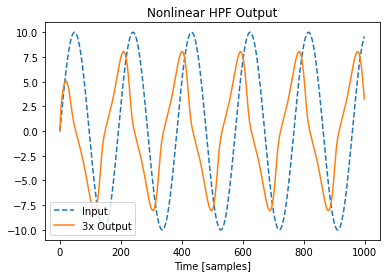

In [7]:
class OnePoleHPF_FB:
    def __init__(self, freq):
        self.z = 0
        self.x1 = 0
        self.b_coeff, self.a_coeff = calc_coefs_freq(freq)

    def lin_output(self, x, fb):
        return self.a_coeff * (self.b_coeff * fb + x - self.x1 + self.z)

    def nonlin_output(self, x, tanh_y, tanh_fb):
        return self.b_coeff * (tanh_fb - tanh_y) + x - self.x1 + self.z

    def get_derivative(self, tanh_y):
        return -self.b_coeff * sech2_with_tanh(tanh_y) - 1.0

    def process_sample(self, x, fb):
        tanh_fb = np.tanh(fb)
        estimate = self.lin_output(x, tanh_fb)

        # newton-raphson update
        N_iter = 1
        for n in range(N_iter):
            tanh_y = np.tanh(estimate)
            residue = self.nonlin_output(x, tanh_y, tanh_fb) - estimate
            estimate -= residue / self.get_derivative(tanh_y)

        self.z = estimate
        self.x1 = x
        return estimate

N = 1000
freq = 500
x = 10 * np.sin(2 * np.pi * np.arange(N) * freq / FS)

y = np.zeros_like(x)
y1 = 0
one_pole = OnePoleHPF_FB(2000)
for n in range(N):
    y[n] = one_pole.process_sample(x[n], -1 * y1)
    y1 = y[n]

plt.plot(x, '--', label='Input')
plt.plot(3 * y, label='3x Output')
plt.title('Nonlinear HPF Output')
plt.xlabel('Time [samples]')
plt.legend()